Використовуючи датасет з файлу cardox.csv (об'єми продажів мережі супермаркетів) виконайте наступну роботу:
1. Проведіть попередній аналіз даних
2. Скорегуйте виявлені аномалії
3. Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)
4. Оберіть модель і проведіть оцінку її метрик
5. Проведіть кінцеву діагностику для отриманої моделі
6. Виконайте прогноз на 30 років
7. Збережіть результати прогнозування у файл

In [ ]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()

In [ ]:
def metrics(real, forecast):

    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values

    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))

    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4))

In [ ]:
df = pd.read_csv('cardox.csv', parse_dates=['date'])
df.head()

Перевіримо, чи є пропущені дані:

In [ ]:
print(df.isnull().sum())

Пропущених даних немає. Далі проведемо попередній аналіз даних на наявність трендовості та сезонності. Для цього спочатку побудуємо графік, щоб побачити загальну динаміку продажів:

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'])
plt.xlabel('Дата')
plt.ylabel('Обсяг продажів')
plt.title('Динаміка продажів')
plt.show()

З графіка видно, що загальна динаміка продажів має тренд зі зростанням продажів з часом.

In [ ]:
# додаємо стовпець з номером місяця
df['month'] = df['date'].dt.month

# додаємо стовпець з номером року
df['year'] = df['date'].dt.year

# побудова графіка зі згорнутою даними по місяцях
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='value', data=df, ci=None)
plt.xlabel('Місяць')
plt.ylabel('Обсяг продажів')
plt.title('Динаміка продажів по місяцях')
plt.show()

# побудова графіка з розгорнутими даними по місяцях та роках
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='value', hue='year', data=df, ci=None)
plt.xlabel('Місяць')
plt.ylabel('Обсяг продажів')
plt.title('Динаміка продажів по місяцях та роках')
plt.show()


З графіків видно, що є сезонність продажів, зокрема підвищення продажів на початку та в кінці кожного року та спад і низькі продажі в середині року. Також можна побачити, що динаміка продажів за місяцями майже однакова для різних років, з незначними відмінностями.

In [ ]:
df = pd.read_csv("cardox.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df.head()

In [ ]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [ ]:
anomalies[anomalies]

In [ ]:
# декомпозиция
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)

# Побудова графіка
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

Оскільки дані мають 1-вимірну структуру, з чітко вираженою сезонністю та зростаючим трендом.
Скористаємось моделлю SARIMAX.

In [107]:
from pmdarima.arima import auto_arima

test_data = df[-20:]
train_data = df[:-20]

model = auto_arima(train_data, seasonal=True, m=12,
                   suppress_warnings=True, stepwise=True, error_action='ignore')

print(model.order)
print(model.seasonal_order)

(2, 1, 1)
(1, 0, 1, 12)


In [110]:
model_sarima = sm.tsa.statespace.SARIMAX(train_data,
                                order=model.order,
                                seasonal_order=model.seasonal_order)

result_sarima = model_sarima.fit()

print(result_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3530      0.043      8.274      0.000       0.269       0.437
ar.L2          0.0868      0.031      2.779      0.005       0.026       0.148
ma.L1         -0.7066      0.038    -18.420      0.000      -0.782      -0.631
ar.S.L12       0.9996      0.000   2906.051      0.000       0.999       1.000
ma.S.L12      -0.8663      0.023    -37.740      0.000      -0.911      -0.821
sigma2         0.0960      0.005     20.583      0.000       0.087       0.105


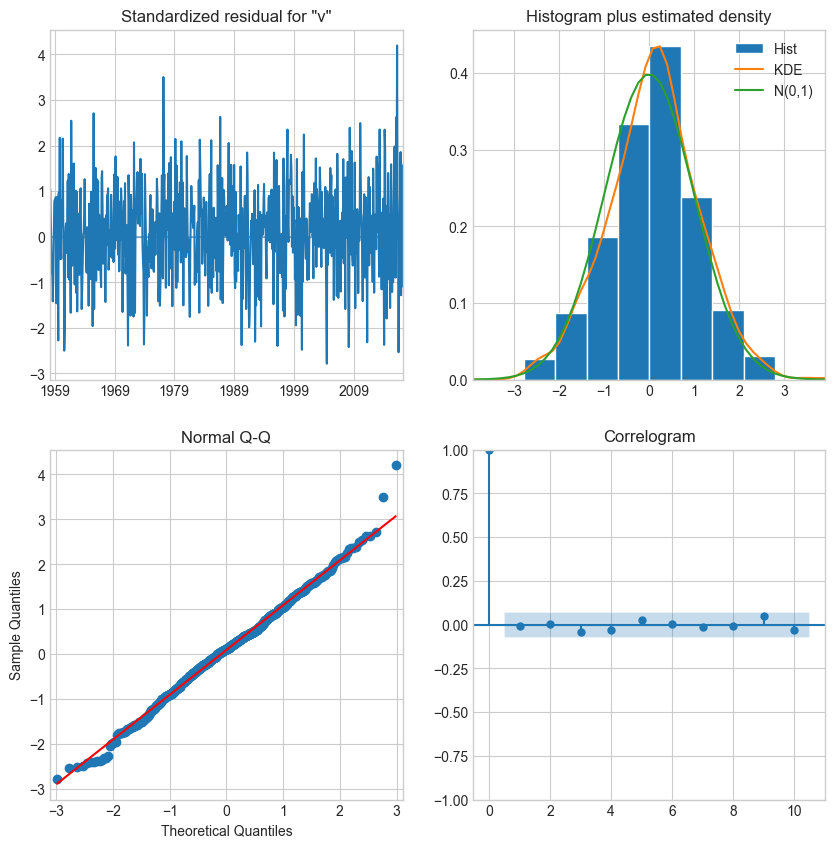

In [111]:
result_sarima.plot_diagnostics()
plt.show()

In [112]:
predicted = result_sarima.predict()
pred = result_sarima.get_prediction()
pred_df = pred.summary_frame()

In [113]:
pred_df.head()

value,mean,mean_se,mean_ci_lower,mean_ci_upper
1958-03-01,0.000000,1000.001381,-1959.966690,1959.966690
1958-04-01,315.709739,1.661670,312.452925,318.966553
1958-05-01,316.929519,1.585616,313.821768,320.037270
1958-06-01,317.276054,1.574340,314.190404,320.361703
1958-07-01,317.085030,1.568832,314.010176,320.159884


In [114]:
test_data.head()

,value
date,
2017-04-01,409.04
2017-05-01,409.69
2017-06-01,408.88
2017-07-01,407.12
2017-08-01,405.13


In [116]:
predict_test = result_sarima.get_prediction(start='2017-04', end='2018-11')

In [115]:
predict_new=result_sarima.get_prediction(start='2018', end='2048')

In [117]:
metrics(test_data, predict_test.predicted_mean)

Тест на стаціонарність:
	T-статистика = -2.174
	P-значення = 0.216
Критичне значення :
	1%: -4.223238279489106 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.189368925619835 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.729839421487603 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.2478
MSE: 0.1012
MAPE: 0.0006
MPE: -0.0002
Стандартна похибка: 0.3181


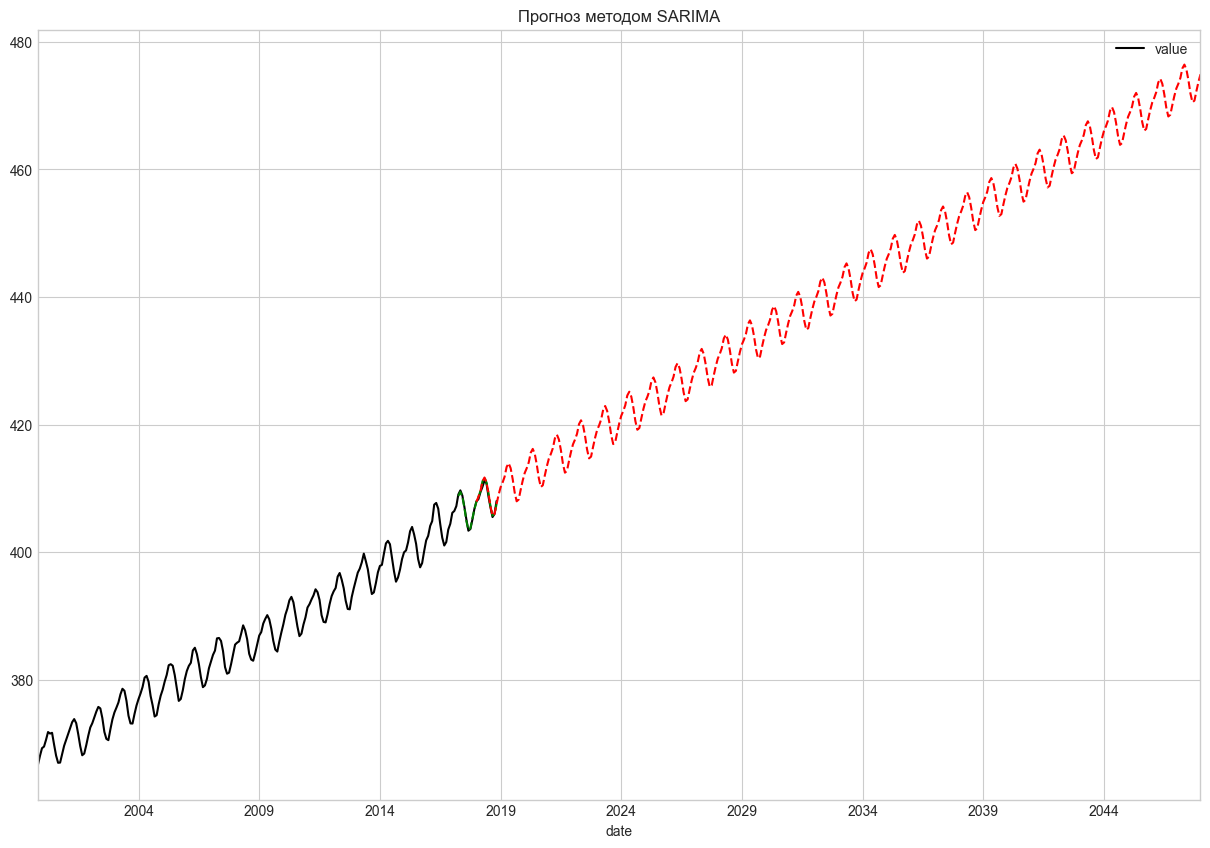

In [120]:
ax = df[500:].plot(figsize=(15,10), color='black', title="Прогноз методом SARIMA" )
predict_test.predicted_mean.plot(ax=ax, style='--', color='green')
predict_new.predicted_mean.plot(ax=ax, style='--', color='red')
plt.show()

In [162]:
pred = pd.DataFrame(predict_new.predicted_mean)
prediction = pd.concat([train_data, test_data], axis=1)
prediction.to_csv('prediction.csv')
prediction.head()

,value,value
date,,
1958-03-01,315.71,NaN
1958-04-01,317.45,NaN
1958-05-01,317.50,NaN
1958-06-01,317.10,NaN
1958-07-01,315.86,NaN
